# Curación - Relaciones Temporales en Textos Médicos

### Recorrido por los datos
Vamos a trabajar primero explorando los datos de ejemplo que se proveen con el challenge.
Para eso hacemos uso de la función lift_data(), que extrae anotaciones de relaciones y las combina en una lista junto con el texto original.

In [21]:
from helpers import lift_dataset
# lift_dataset devuelve un iterador
dataset = list(lift_dataset('../dataset/2012-07-15.original-annotation.release'))
len(dataset)

33635

In [22]:
dataset[:5]

[['EVENT="Admission" 1:0 1:0',
  'TIMEX3="2014-03-31" 2:0 2:0',
  'type="SIMULTANEOUS"\n',
  'Admission Date :\n2014-03-31\n',
  '193.xml.tlink'],
 ['EVENT="Discharge" 3:0 3:0',
  'TIMEX3="2014-04-09" 4:0 4:0',
  'type="SIMULTANEOUS"\n',
  'Discharge Date :\n2014-04-09\n',
  '193.xml.tlink'],
 ['EVENT="admitted" 9:4 9:4',
  'EVENT="Nantucket Cottage Hospital" 9:11 9:13',
  'type="OVERLAP"\n',
  'The patient has been admitted 5 x in the past to Nantucket Cottage Hospital since 11-30 for encephalopathy .\n',
  '193.xml.tlink'],
 ['TIMEX3="2014-04-04" 48:1 48:1',
  'EVENT="labs" 48:3 48:3',
  'type="SIMULTANEOUS"\n',
  'On 2014-04-04 , labs were as follows :\n',
  '193.xml.tlink'],
 ['EVENT="WBC" 49:0 49:0',
  'TIMEX3="2014-04-04" 48:1 48:1',
  'type="SIMULTANEOUS"\n',
  'On 2014-04-04 , labs were as follows :\nWBC of 8.3 ; hematocrit of 30.6 ; platelets 69 ; sodium 132 ; 3.9 , 102 , 22 , serum creatinine of 13 and 1.1 .\n',
  '193.xml.tlink']]

In [23]:
import pandas as pd
df = pd.DataFrame(dataset)
df.columns = ['event_1', 'event_2', 'relationship', 'text', 'source_file']
df[:6]

,event_1,event_2,relationship,text,source_file
0,"EVENT=""Admission"" 1:0 1:0","TIMEX3=""2014-03-31"" 2:0 2:0","type=""SIMULTANEOUS""\n",Admission Date :\n2014-03-31\n,193.xml.tlink
1,"EVENT=""Discharge"" 3:0 3:0","TIMEX3=""2014-04-09"" 4:0 4:0","type=""SIMULTANEOUS""\n",Discharge Date :\n2014-04-09\n,193.xml.tlink
2,"EVENT=""admitted"" 9:4 9:4","EVENT=""Nantucket Cottage Hospital"" 9:11 9:13","type=""OVERLAP""\n",The patient has been admitted 5 x in the past ...,193.xml.tlink
3,"TIMEX3=""2014-04-04"" 48:1 48:1","EVENT=""labs"" 48:3 48:3","type=""SIMULTANEOUS""\n","On 2014-04-04 , labs were as follows :\n",193.xml.tlink
4,"EVENT=""WBC"" 49:0 49:0","TIMEX3=""2014-04-04"" 48:1 48:1","type=""SIMULTANEOUS""\n","On 2014-04-04 , labs were as follows :\nWBC of...",193.xml.tlink
5,"EVENT=""hematocrit"" 49:4 49:4","TIMEX3=""2014-04-04"" 48:1 48:1","type=""SIMULTANEOUS""\n","On 2014-04-04 , labs were as follows :\nWBC of...",193.xml.tlink


## Tokenización
Tokenizamos los datos y calculamos el tamaño de vocabulario, para ello se puede usar el siguiente código ejemplo con SpaCy. (reemplazar esto con el código que hace la tokenización sobre la variable dataset del punto anterior).
El objetivo aquí es achicar el tamaño del vocabulario.
El texto en el punto anterior está en el penúltimo elemento de cada lista que comprende cada punto de datos.

In [24]:
import spacy
spacy_nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
df['text_as_doc'] = df['text'].apply(lambda x: spacy_nlp(x))
df['text_tokens'] = df['text_as_doc'].apply(lambda doc: [token.text for token in doc])
df['text_tokens'][:5]

0     [Admission, Date, :, \n, 2014, -, 03, -, 31, \n]
1     [Discharge, Date, :, \n, 2014, -, 04, -, 09, \n]
2    [The, patient, has, been, admitted, 5, x, in, ...
3    [On, 2014, -, 04, -, 04, ,, labs, were, as, fo...
4    [On, 2014, -, 04, -, 04, ,, labs, were, as, fo...
Name: text_tokens, dtype: object

In [25]:
# imprimimos el tamaño del vocabulario
vocab = []
for tokens in df['text_tokens']:
  vocab.extend(tokens)
vocab = set(vocab)
len(vocab)

8703

## Lematización
Seguimos usando SpaCy, esta vez para obtener lemas. 

Aprovechamos y ambin sacamos stopwords.

In [26]:
df['text_lemma'] = df['text_as_doc'].apply(lambda doc: [word.lemma_ for word in doc if word.is_stop == False])
df['text_lemma'][:5]

0     [Admission, Date, :, \n, 2014, -, 03, -, 31, \n]
1     [Discharge, Date, :, \n, 2014, -, 04, -, 09, \n]
2    [patient, admit, 5, x, past, Nantucket, Cottag...
3          [2014, -, 04, -, 04, ,, lab, follow, :, \n]
4    [2014, -, 04, -, 04, ,, lab, follow, :, \n, WB...
Name: text_lemma, dtype: object

## Sigamos normalizando
Algunas ideas, los números se pueden reemplazar por un token especial, _NUM_, las fechas también. 
Utilizar el módulo de regexes de Python.


In [27]:
def count(df, col_name, patterns):
    count = sum([len(df[df[col_name].str.contains(pattern, regex=True) == True].index) for pattern in patterns])
    return count

def replace_with_patterns(df, col_name, patterns, replace_with):
    for pattern in patterns:
        df[col_name] = df[col_name].str.replace(pattern, replace_with, regex=True)

In [28]:
# A partir de los lemmas recreamamos el texto bajo una nueva columna que se normalizara.
df['text_norm'] = df['text_lemma'].apply(lambda x: ' '.join(x))

# lower case
df['text_norm'] = df['text_norm'].str.lower()

# Cantidad de numeros.
numbers_patterns = ['\d{1,9}\.{0,1}\d{0,4}']
print('Cantidad de numeros en texto original: ', count(df, 'text', numbers_patterns))

# Cantidad de fechas.
dates_patterns = ['^\d{4}\s{0,1}-\s{0,1}\d{2}\s{0,1}-\s{0,1}\d{2}$', '\d{4}\s{0,1}-\s{0,1}\d{2}\s{0,1}-\s{0,1}\d{2}', '\d{1,2}\s{0,1}/\s{0,1}\d{1,2}\s{0,1}/\s{0,1}\d{2,4}', '\d{1,2}\s{0,1}-\s{0,1}\d{1,2}']
print('Cantidad de fechas en texto original: ', count(df, 'text', dates_patterns))

# normalizamos fechas
replace_with_patterns(df, 'text_norm', dates_patterns, 'DATE')
print('Cantidad de fechas en texto normalizado: ', count(df, 'text_norm', dates_patterns))

# normalizamos números
replace_with_patterns(df, 'text_norm', numbers_patterns, 'NUM')
print('Cantidad de numeros en texto normalizado: ', count(df, 'text_norm', numbers_patterns))

print(df['text_norm'][:5])


Cantidad de numeros en texto original:  24563
Cantidad de fechas en texto original:  28513
Cantidad de fechas en texto normalizado:  0
Cantidad de numeros en texto normalizado:  0
0                          admission date : \n DATE \n
1                          discharge date : \n DATE \n
2    patient admit NUM x past nantucket cottage hos...
3                               DATE , lab follow : \n
4    DATE , lab follow : \n wbc NUM ; hematocrit NU...
Name: text_norm, dtype: object


In [29]:
# removemos caracter de nueva linea
print(len(df[df['text'].str.contains('\n', regex=False) == True]))
print(df['text'][:1])
df['text_norm'] = df['text_norm'].str.replace('\n', '')
print(len(df[df['text_norm'].str.contains('\n', regex=False) == True]))
print(df['text_norm'][:1])

33635
0    Admission Date :\n2014-03-31\n
Name: text, dtype: object
0
0    admission date :  DATE 
Name: text_norm, dtype: object


In [30]:
# sacamos signos de puntuacion
df['text_norm_as_doc'] = df['text_norm'].apply(lambda x: spacy_nlp(x))
df['text_norm_without_punck'] = df['text_norm_as_doc'].apply(lambda doc: [token.text for token in doc if token.is_punct == False])
df['text_norm_without_punck'] = df['text_norm_without_punck'].apply(lambda x: ' '.join(x))

## Volvemos a calcular el tamaño del vocabulario
El tamaño debería haberse reducido ya que hemos colapsado cosas distintas hacia los mismos tokens. 
Más adelante vamos a ver porque esto es interesante.

In [31]:
# calculamos el tamaño del vocabulario luego de normalizar
df['text_norm_without_punck_as_doc'] = df['text_norm_without_punck'].apply(lambda x: spacy_nlp(x))
df['text_norm_without_punck_tokens'] = df['text_norm_without_punck_as_doc'].apply(lambda doc: [token.text for token in doc])
vocab = []
for tokens in df['text_norm_tokens']:
  vocab.extend(tokens)
vocab = set(vocab)
len(vocab)

5625

## Limpieza de relaciones.

In [32]:
# cantidad de relaciones.
df['relationship'].value_counts()

type="BEFORE"\n            13467
type="OVERLAP"\n            7061
type="SIMULTANEOUS"\n       4306
type="BEFORE_OVERLAP"\n     3249
type="AFTER"\n              2211
type="DURING"\n             1037
type="BEGUN_BY"\n            996
type="ENDED_BY"\n            797
type="simultaneous"\n        419
type=""\n                     92
Name: relationship, dtype: int64

In [33]:
# limpiamos para que quede solo el nombre de la realcion.
df['relationship_norm'] = df['relationship']
df.relationship_norm = df.relationship_norm.str.replace('type="BEFORE"\n', 'BEFORE', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type="OVERLAP"\n', 'OVERLAP', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type="SIMULTANEOUS"\n', 'SIMULTANEOUS', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type="simultaneous"\n', 'SIMULTANEOUS', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type="BEFORE_OVERLAP"\n', 'BEFORE_OVERLAP', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type="AFTER"\n', 'AFTER', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type="DURING"\n', 'DURING', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type="BEGUN_BY"\n', 'BEGUN_BY', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type="ENDED_BY"\n', 'ENDED_BY', regex=True)
df.relationship_norm = df.relationship_norm.str.replace('type=""\n', '', regex=True)
# Hay un relacion con nombe vacio, la vamos a eliminar.
df = df.drop(df[df.relationship_norm == ''].index)
print(df.relationship_norm.value_counts())

BEFORE            13467
OVERLAP            7061
SIMULTANEOUS       4725
BEFORE_OVERLAP     3249
AFTER              2211
DURING             1037
BEGUN_BY            996
ENDED_BY            797
Name: relationship_norm, dtype: int64


## Limpieza de eventos.

In [34]:
# Separamos el nombre del tipo del evento del texto del evento.

In [35]:
# Tipo.
df['event_1_type'] = df.apply(
    lambda row: 'EVENT' if 'EVENT' in row['event_1'] else 'TIMEX3',
    axis=1
)
df['event_2_type'] = df.apply(
    lambda row: 'EVENT' if 'EVENT' in row['event_2'] else 'TIMEX3',
    axis=1
)

In [36]:
# Texto.
df['event_1_norm'] = df['event_1']
df.event_1_norm = df.event_1_norm.str.extract(r'(\".*\")', expand=False)
df.event_1_norm = df.event_1_norm.str.strip('"')
df.event_1_norm = df.event_1_norm.str.strip()
df.event_1_norm = df.event_1_norm.str.lower()

df['event_2_norm'] = df['event_2']
df.event_2_norm = df.event_2_norm.str.extract(r'(\".*\")', expand=False)
df.event_2_norm = df.event_2_norm.str.strip('"')
df.event_2_norm = df.event_2_norm.str.strip()
df.event_2_norm = df.event_2_norm.str.lower()

In [37]:
# Normalizamos fechas y numeros en el texto de evento.

# Cantidad de numeros.
print('Cantidad de numeros en event_1: ', count(df, 'event_1', numbers_patterns))
print('Cantidad de numeros en event_2: ', count(df, 'event_2', numbers_patterns))

# Cantidad de fechas.
print('Cantidad de fechas en event_1: ', count(df, 'event_1', dates_patterns))
print('Cantidad de fechas en event_2: ', count(df, 'event_2', dates_patterns))

# normalizamos fechas
replace_with_patterns(df, 'event_1_norm', dates_patterns, 'DATE')
replace_with_patterns(df, 'event_2_norm', dates_patterns, 'DATE')
print('Cantidad de fechas en event_1_norm: ', count(df, 'event_1_norm', dates_patterns))
print('Cantidad de fechas en event_2_norm: ', count(df, 'event_2_norm', dates_patterns))

# normalizamos números
replace_with_patterns(df, 'event_1_norm', numbers_patterns, 'NUM')
replace_with_patterns(df, 'event_2_norm', numbers_patterns, 'NUM')
print('Cantidad de numeros en event_1_norm: ', count(df, 'event_1_norm', numbers_patterns))
print('Cantidad de numeros en event_2_norm: ', count(df, 'event_2_norm', numbers_patterns))

Cantidad de numeros en event_1:  33543
Cantidad de numeros en event_2:  33543
Cantidad de fechas en event_1:  206
Cantidad de fechas en event_2:  25540
Cantidad de fechas en event_1_norm:  0
Cantidad de fechas en event_2_norm:  0
Cantidad de numeros en event_1_norm:  0
Cantidad de numeros en event_2_norm:  0


In [38]:
df[:5]

,event_1,event_2,relationship,text,source_file,text_as_doc,text_tokens,text_lemma,text_norm,text_norm_as_doc,text_norm_without_punck,text_norm_tokens,relationship_norm,event_1_type,event_2_type,event_1_norm,event_2_norm
0,"EVENT=""Admission"" 1:0 1:0","TIMEX3=""2014-03-31"" 2:0 2:0","type=""SIMULTANEOUS""\n",Admission Date :\n2014-03-31\n,193.xml.tlink,"(Admission, Date, :, \n, 2014, -, 03, -, 31, \n)","[Admission, Date, :, \n, 2014, -, 03, -, 31, \n]","[Admission, Date, :, \n, 2014, -, 03, -, 31, \n]",admission date : DATE,"(admission, date, :, , DATE)",admission date DATE,"[admission, date, :, , DATE]",SIMULTANEOUS,EVENT,TIMEX3,admission,DATE
1,"EVENT=""Discharge"" 3:0 3:0","TIMEX3=""2014-04-09"" 4:0 4:0","type=""SIMULTANEOUS""\n",Discharge Date :\n2014-04-09\n,193.xml.tlink,"(Discharge, Date, :, \n, 2014, -, 04, -, 09, \n)","[Discharge, Date, :, \n, 2014, -, 04, -, 09, \n]","[Discharge, Date, :, \n, 2014, -, 04, -, 09, \n]",discharge date : DATE,"(discharge, date, :, , DATE)",discharge date DATE,"[discharge, date, :, , DATE]",SIMULTANEOUS,EVENT,TIMEX3,discharge,DATE
2,"EVENT=""admitted"" 9:4 9:4","EVENT=""Nantucket Cottage Hospital"" 9:11 9:13","type=""OVERLAP""\n",The patient has been admitted 5 x in the past ...,193.xml.tlink,"(The, patient, has, been, admitted, 5, x, in, ...","[The, patient, has, been, admitted, 5, x, in, ...","[patient, admit, 5, x, past, Nantucket, Cottag...",patient admit NUM x past nantucket cottage hos...,"(patient, admit, NUM, x, past, nantucket, cott...",patient admit NUM x past nantucket cottage hos...,"[patient, admit, NUM, x, past, nantucket, cott...",OVERLAP,EVENT,EVENT,admitted,nantucket cottage hospital
3,"TIMEX3=""2014-04-04"" 48:1 48:1","EVENT=""labs"" 48:3 48:3","type=""SIMULTANEOUS""\n","On 2014-04-04 , labs were as follows :\n",193.xml.tlink,"(On, 2014, -, 04, -, 04, ,, labs, were, as, fo...","[On, 2014, -, 04, -, 04, ,, labs, were, as, fo...","[2014, -, 04, -, 04, ,, lab, follow, :, \n]","DATE , lab follow :","(DATE, ,, lab, follow, :)",DATE lab follow,"[DATE, ,, lab, follow, :]",SIMULTANEOUS,TIMEX3,EVENT,DATE,labs
4,"EVENT=""WBC"" 49:0 49:0","TIMEX3=""2014-04-04"" 48:1 48:1","type=""SIMULTANEOUS""\n","On 2014-04-04 , labs were as follows :\nWBC of...",193.xml.tlink,"(On, 2014, -, 04, -, 04, ,, labs, were, as, fo...","[On, 2014, -, 04, -, 04, ,, labs, were, as, fo...","[2014, -, 04, -, 04, ,, lab, follow, :, \n, WB...","DATE , lab follow : wbc NUM ; hematocrit NUM ...","(DATE, ,, lab, follow, :, , wbc, NUM, ;, hema...",DATE lab follow wbc NUM hematocrit NUM plate...,"[DATE, ,, lab, follow, :, , wbc, NUM, ;, hema...",SIMULTANEOUS,EVENT,TIMEX3,wbc,DATE


In [39]:
# Guardamos el df.
df.to_csv('../dataset/data_pos_curacion.csv')

## Graficamos tokens mas frecuentes

In [46]:
from collections import Counter
df['text_norm_as_doc'] = df['text_norm'].apply(lambda x: spacy_nlp(x))
df['text_norm_tokens'] = df['text_norm_as_doc'].apply(lambda doc: [token.text for token in doc])
words = []
for tokens in df['text_norm_tokens']:
  words.extend(tokens)
word_freq = Counter(words)
common_words = [x[0] for x in word_freq.most_common(20)]
common_words_count = [x[1] for x in word_freq.most_common(20)]

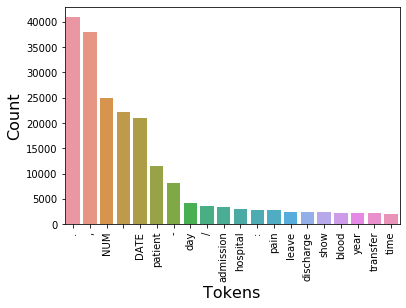

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(x=common_words, y=common_words_count)
ax.set_xlabel(xlabel='Tokens', fontsize=16)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.xticks(rotation='vertical')
plt.show();

In [67]:
df['text_norm_without_punck_as_doc'] = df['text_norm_without_punck'].apply(lambda x: spacy_nlp(x))
df['text_norm_without_punck_tokens'] = df['text_norm_without_punck_as_doc'].apply(lambda doc: [token.text for token in doc])
words = []
for tokens in df['text_norm_without_punck_tokens']:
  words.extend(tokens)
word_freq = Counter(words)
common_words = [x[0] for x in word_freq.most_common(20)]
common_words_count = [x[1] for x in word_freq.most_common(20)]

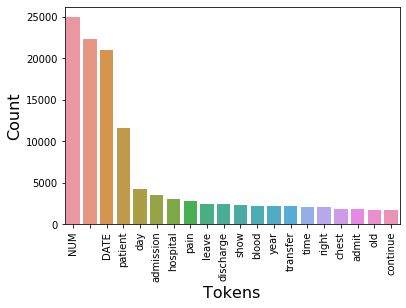

In [68]:
ax = sns.barplot(x=common_words, y=common_words_count)
ax.set_xlabel(xlabel='Tokens', fontsize=16)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.xticks(rotation='vertical')
plt.show();